In [28]:
from mxnet import init
from mxnet import gluon
from mxnet.gluon import nn
import mxnet as mx
from mxnet import image
import sys
sys.path.append('..')
from utils import *
ctx = mx.cpu()

In [29]:
def pic_aug(pic):
    pic = nd.array(pic)
    pic = nd.transpose(pic, (0, 2, 3, 1))
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=36, rand_crop=True, rand_mirror=True)
    a = nd.zeros((len(pic),32,32,3))
    for i in range(len(pic)):
        im = pic[i]
        for aug in auglist:
            im = aug(im)
        a[i] = im
    a  = nd.transpose(a, (0, 3, 1, 2))
    return a

class Residual(nn.Block):
    def __init__(self, channels, same_shape=True, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.same_shape = same_shape
        with self.name_scope():
            strides = 1 if same_shape else 2
            self.conv1 = nn.Conv2D(channels, kernel_size=3, padding=1, strides=strides)
            self.bn1 = nn.BatchNorm()
            self.conv2 = nn.Conv2D(channels, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm()
            if not same_shape:
                self.conv3 = nn.Conv2D(channels, kernel_size=1, strides=strides)
    def forward(self, x):
        out = nd.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if not self.same_shape:
            x = self.conv3(x)
        return nd.relu(out + x)

class ResNet(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(ResNet, self).__init__(**kwargs)
        with self.name_scope(): 
            b1 = nn.Conv2D(16, kernel_size=3, strides=1, padding=1)
            b2 = nn.Sequential()
            for _ in range(8):
                b2.add(Residual(16))
            b3 = nn.Sequential()
            b3.add(Residual(32, same_shape=False))
            for _ in range(7):
                b3.add(Residual(32))
            b4 = nn.Sequential()
            b4.add(Residual(64, same_shape=False))
            for _ in range(7):
                b4.add(Residual(64))
            b5 = nn.Sequential()
            b5.add(nn.AvgPool2D(pool_size=3),nn.Dense(num_classes))
            self.net = nn.Sequential()
            self.net.add(b1, b2, b3, b4, b5)
    def forward(self, x):
        out = x
        for i, b in enumerate(self.net):
            out = b(out)
        return out

In [30]:
batch_size = 256
train_data, test_data = load_cifar(50, 10, batch_size, route = '/Users/Sinyer/Documents/Python/data')

In [31]:
net = ResNet(10)
net.initialize(ctx=ctx, init=init.Xavier())
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.05, 'momentum': 0.9, 'wd': 5e-4})

Epoch 0, Loss: 4.258605, Train acc 0.080000, Test acc 0.200000, Time 2.739744
Epoch 1, Loss: 10.149881, Train acc 0.160000, Test acc 0.300000, Time 2.756449
Epoch 2, Loss: 31.281218, Train acc 0.100000, Test acc 0.200000, Time 2.681920


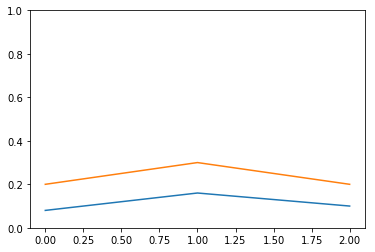

In [32]:
epochs = 80
lr_period = 60
lr_decay = 0.1

a = []
b = []
for epoch in range(epochs):
    if epoch > 0 and epoch % lr_period == 0:
        trainer.set_learning_rate(trainer.learning_rate * lr_decay)
    train_loss = 0.
    train_acc = 0.
    batch = 0
    start = time()
    for data, label in train_data:
        data = pic_aug(data)
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            L = loss(output, label)
        L.backward()
        trainer.step(data.shape[0])
        train_loss += nd.mean(L).asscalar()
        train_acc += accuracy(output, label)
        batch += 1
        if print_batches and batch % None == 0:
            print("Batch %d, Loss: %f, Train acc %f" % (batch, train_loss/batch, train_acc/batch))
    a.append(train_acc/batch)
    test_acc = evaluate_accuracy(test_data, net, ctx)
    b.append(test_acc)
    if epoch%1 == 0:
        print("Epoch %d, Loss: %f, Train acc %f, Test acc %f, Time %f" % (
            epoch, train_loss/batch, train_acc/batch, test_acc, time() - start))
plt.plot(np.arange(0, epochs),a,np.arange(0, epochs),b)
plt.ylim(0, 1)
plt.show()